In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from src.pipeline import find_flux, find_noise_square
import warnings
import pandas as pd
from astropy.wcs import WCS
warnings.filterwarnings("ignore")

In [25]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '53.0_-28.0'

# Set the aperture size (pixels)
aperture_size = 2

In [4]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits') as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

ra_reference = cat['RIGHT_ASCENSION']
dec_reference = cat['DECLINATION']

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1464   96164R x 470C   [K, D, D, D, D, K, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

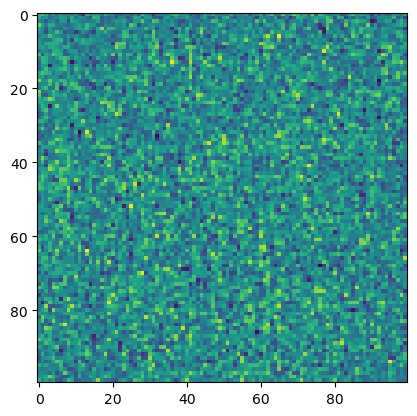

In [5]:
files = glob.glob(f'{location}/{field}/u_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[1]
    y0_rubin, x0_rubin, y1_rubin, x1_rubin = find_noise_square(hdul[1].data, 100)
    plt.imshow(hdul[1].data[y0_rubin:y1_rubin, x0_rubin:x1_rubin])
    plt.show()

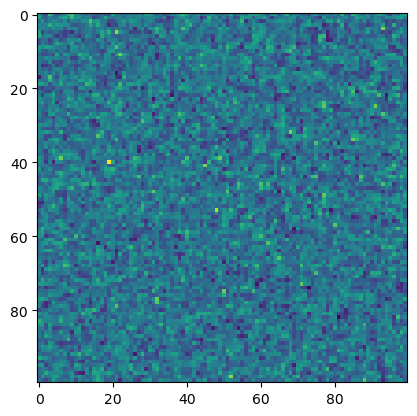

In [43]:
catalog = Table.read(f'{location}/{field}/VIS.cat', format='fits', hdu=2)
files = glob.glob(f'{location}/{field}/VIS_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[0]
    y0_euclid, x0_euclid, y1_euclid, x1_euclid = find_noise_square(hdul[0].data[:3400, :3400], 100)
    plt.imshow(hdul[0].data[y0_euclid:y1_euclid, x0_euclid:x1_euclid])
    plt.show()

In [26]:
fluxes = {}
sigmas = {}
rubin_filters = ['u', 'g', 'r', 'i', 'z', 'y']
euclid_filters = ['VIS', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']

fluxes['ra'] = ra_reference
fluxes['dec'] = dec_reference

rubin_filters = ['g', 'r', 'i']
for filter in rubin_filters:
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")][0]
    psf_file = [file for file in files if file.endswith("psf.fits")][0]
    fluxes[filter], sigmas[filter] = find_flux(image_file, "Rubin", aperture_size, ra_reference, dec_reference, psf_path=psf_file, correlated=2, noise_x0=x0_rubin, noise_x1=x1_rubin, noise_y0=y0_rubin, noise_y1=y1_rubin)

# euclid_filters = ['DES-G', 'DES-R', 'DES-I']
# for filter in euclid_filters:
#     files = glob.glob(f'{location}/{field}/{filter}_*.fits')
#     image_file = [file for file in files if not file.endswith("psf.fits")][0]
#     fluxes[filter], sigmas[filter] = find_flux(image_file, "Euclid", aperture_size, ra_reference, dec_reference, catalog_path=f'{location}/{field}/{filter}.cat', tilesize = 1200, correlated=None, noise_x0=x0_euclid, noise_x1=x1_euclid, noise_y0=y0_euclid, noise_y1=y1_euclid)

Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function


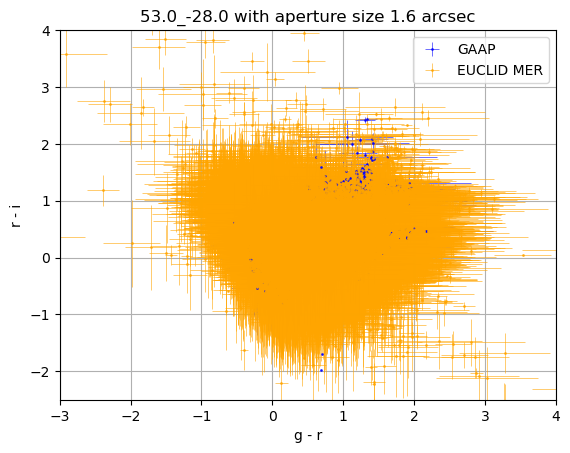

In [10]:
filter_1 = 'g'   # e.g., master_table column name
filter_2 = 'r'
filter_3 = 'r'
filter_4 = 'i'

plot_error = True

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (sigmas[filter_1] / fluxes[filter_1])**2 +
        (sigmas[filter_2] / fluxes[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (sigmas[filter_3] / fluxes[filter_3])**2 +
        (sigmas[filter_4] / fluxes[filter_4])**2
    )

    # Optional: filter points with very large errors
    mask = (xerr**2 + yerr**2 < 1)
    new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    gaap_error = xerr**2 + yerr**2
    # plt.show()
    # Plot
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    )
    # plt.title(f'{field} with aperture size {8/5} arcsec')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-1, 4)
    # plt.ylim(-2.5, 2.5)
    # plt.show()
    x_color = -2.5 * np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])
    y_color = -2.5 * np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_G_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_I_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])**2
    )

    mask = (xerr**2 + yerr**2 < 1)
    new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    euclid_error = xerr**2 + yerr**2
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='EUCLID MER'
    )

    plt.title(f'{field} with aperture size {8/5} arcsec')
    plt.xlabel(f'{filter_1} - {filter_2}')
    plt.ylabel(f'{filter_3} - {filter_4}')
    plt.xlim(-3, 4)
    plt.ylim(-2.5, 4)
    plt.legend()
    plt.show()

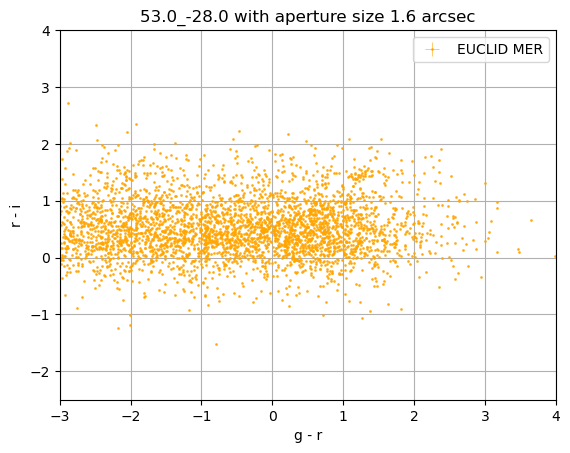

In [27]:
filter_1 = 'g'   # e.g., master_table column name
filter_2 = 'r'
filter_3 = 'r'
filter_4 = 'i'

plot_error = False

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    # y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (sigmas[filter_1] / fluxes[filter_1])**2 +
        (sigmas[filter_2] / fluxes[filter_2])**2
    )
    # yerr = 2.5 / np.log(10) * np.sqrt(
    #     (sigmas[filter_3] / fluxes[filter_3])**2 +
    #     (sigmas[filter_4] / fluxes[filter_4])**2
    # )

    # Optional: filter points with very large errors
    # mask = (xerr**2 + yerr**2 < 1)
    # new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    # gaap_error = xerr**2 + yerr**2
    # # plt.show()
    # # Plot
    # plt.errorbar(
    #     x_color[mask], y_color[mask],
    #     xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    #     fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    # )
    # plt.title(f'{field} with aperture size {8/5} arcsec')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-1, 4)
    # plt.ylim(-2.5, 2.5)
    # plt.show()
    y_color = -2.5 * np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])
    # y_color = -2.5 * np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])

    # Compute errors from sigma dictionary
    yerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_G_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2
    )
    # yerr = 2.5 / np.log(10) * np.sqrt(
    #     (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2 +
    #     (cat['FLUXERR_I_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])**2
    # )

    mask = (xerr**2 + yerr**2 < 1)
    # new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    # euclid_error = xerr**2 + yerr**2
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='EUCLID MER'
    )

    plt.title(f'{field} with aperture size {8/5} arcsec')
    plt.xlabel(f'{filter_1} - {filter_2}')
    plt.ylabel(f'{filter_3} - {filter_4}')
    plt.xlim(-3, 4)
    plt.ylim(-2.5, 4)
    plt.legend()
    plt.show()

In [23]:
print(np.sum(np.isnan(euclid_error)))

16


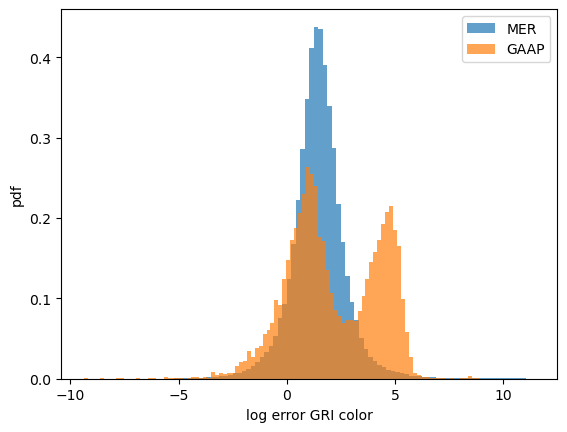

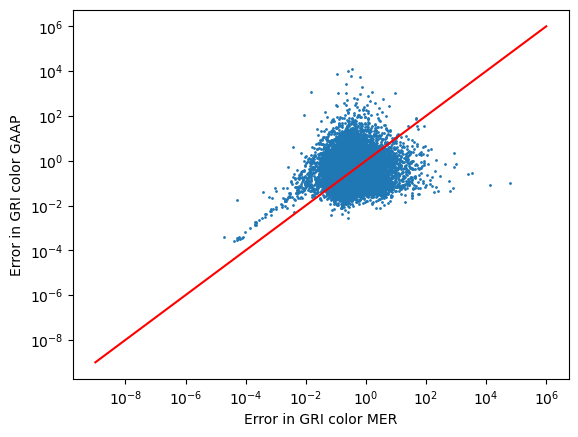

4.727342039052144


In [28]:
plt.hist(np.log(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUXERR_G_EXT_DECAM_2FWHM_APER']), bins=100, density=True, alpha=0.7, label='MER')
plt.hist(np.log(fluxes['g'][fluxes['g']>0]/sigmas['g']), bins=100, density=True, alpha=0.7, label='GAAP')
plt.xlabel('log error GRI color')
plt.ylabel('pdf')
plt.legend()
plt.show()
plt.scatter(yerr, xerr, s=1)
plt.plot([1e-9, 1e6], [1e-9, 1e6], '-', c='r', label='Equality')
plt.loglog()
plt.xlabel('Error in GRI color MER')
plt.ylabel('Error in GRI color GAAP')
plt.show()
print(np.nanmean(xerr[xerr<1e1]/yerr[xerr<1e1]))
# print(np.sum(xerr>yerr), np.sum(xerr<yerr))

Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image


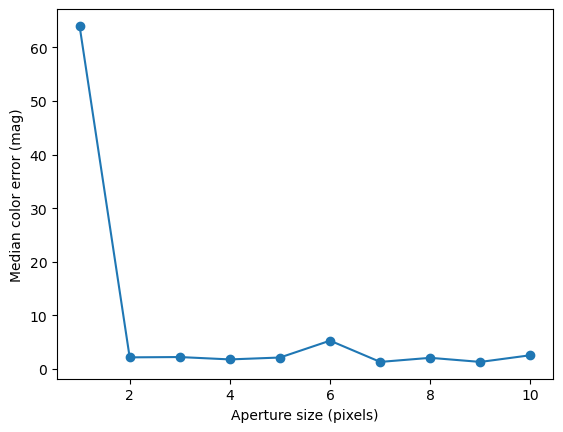

In [16]:
sizes = np.linspace(1, 10, 10)
filter_1 = 'g'   # e.g., master_table column name
filter_2 = 'r'
filters = [filter_1, filter_2]
color_errors = np.zeros_like(sizes)
color_errors[:] = np.nan
fluxes = {}
sigmas = {}
for i, size in enumerate(sizes):
    for filter in filters:
        files = glob.glob(f'{location}/{field}/{filter}_*.fits')
        image_file = [file for file in files if not file.endswith("psf.fits")][0]
        psf_file = [file for file in files if file.endswith("psf.fits")][0]
        fluxes[filter], sigmas[filter] = find_flux(image_file, "Rubin", size, ra_reference, dec_reference, psf_path=psf_file, correlated=5, noise_x0=x0_rubin, noise_x1=x1_rubin, noise_y0=y0_rubin, noise_y1=y1_rubin)
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    xerr = 2.5 / np.log(10) * np.sqrt(
        (sigmas[filter_1] / fluxes[filter_1])**2 +
        (sigmas[filter_2] / fluxes[filter_2])**2
    )
    color_errors[i] = np.nanmean(xerr[np.isfinite(xerr)])
plt.plot(sizes, color_errors, '-o')
plt.xlabel('Aperture size (pixels)')
plt.ylabel('Median color error (mag)')
plt.show()

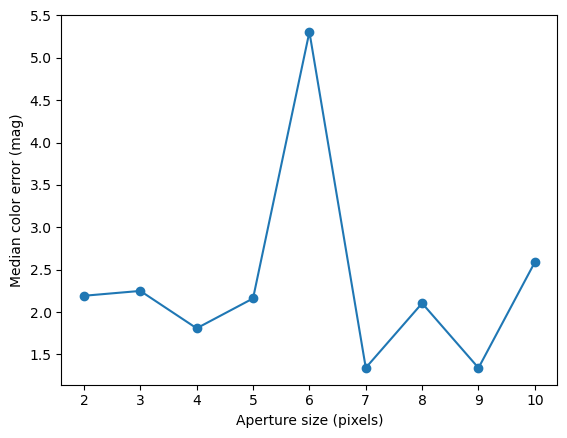

In [17]:
plt.plot(sizes[1:], color_errors[1:], '-o')
plt.xlabel('Aperture size (pixels)')
plt.ylabel('Median color error (mag)')
plt.show()